# Predcited Heart Disease Diagnoses - DSCI100 Group Project

## Group Members
* Gary Wu 
* Abner Inder Singh Bal
* Taarika Rajani

## Index
* Introduction 
* Dataset Attribute Information
* Reasoning Behind Choosing Column Choice
* Method and Results
* Discussion
* Citation Used

## Introduction

#### Background Information on our topic
* Heart disease is one of the leading causes of death in developed nations as it is considered a lifestyle related disorder (1 person dies every 36 seconds from cardiovascular disease in the US). As rates of heart disease increase and strain medical systems around the world, our group has chosen to explore how we can use predictor variables (in the form of patient data) to predict diagnoses of disease. Perhaps using such data to make predictions can save costs associated with expensive medical testing and can identify patients at greater risk for diagnoses (who could then be allocated further testing resources).

#### Question 
* How can we use predictor variables (specific patient data) to predict the presence of heart disease? Specifically, can age, thalch(maximum heart rateO data be used to predict patients' heart disease diagnoses?

#### Dataset Description
* The Cleveland Heart Disease Dataset (processed.cleveland.data) contains data on 76 patient attributes related to heart disease. All published experiments have previously used a subset of 14 attributes most relevant to heart disease. The dataset is preprocessed and contains data which is already in a tidy format. Of the 14 columns previously used in experimental analyses we are going to use the 3 columns: 
age , thalach , and num.


  

## Dataset Attribute Information:
* Only 3 out of  14 columns will be used
 * Age : age in years     
 * thalac : maximum heart rate achieved
 * num : diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing (no disease)
        -- Value 1: > 50% diameter narrowing (early stage disease)
        -- Values above 1: Heart disease


## Reasoning Behind Choosing Column Choice
As we are using a classification model we are not able to use factors as predictors as they provide very inaccurate results in a classification model, therefore we were only left with 4 numeric columns in the table as predictors which were age, thalac , chol, and restecg . Studies showed that all these columns may have a relation to heart disease. According to the National Institute on Aging "aging can cause changes in the heart and blood vessels that may increase a person's risk of developing cardiovascular disease", this indicates a positive relationship between age and num (U.S. Department of Health and Human Services). The National Library Of Medicine states that "maximal exercise-induced heart rate inversely associated with cardiovascular mortality", this indicates an inverse relation between thalac and num (Sandvik L;Erikssen J;Ellestad M;Erikssen G;Thaulow E;Mundal R;Rodahl K;). To further back up these studies we tested all combinations of the 4 predictors and achieved a maximum accuracy in predicting num with the combination of age and thalach as predictors.

## Method And Results

#### Part 0 : Configuration And Testing For Maximum Accuracy
* Testing all combinations of predictors to achieve maximum accuracy .

In [1]:
# If you want change predictor, change predictors below


# Code part 0, config

#[Note: recipe(target ~ ., data = heart_data_train)
# predictors <- c("age", "trestbps", "chol")
# predictors <- c("age", "trestbps", "chol", "thalach")
predictors <- c("age", "thalach")
# Example: predictors <- c("age", "chol") == 
#          recipe(num ~ age+chol, data = heart_data_train)
# predictors: all predictors

# Remember: change K at Code part 5


# Config - part 6, result visualizing, x_var: x-axis variable name, y_var: y-axis
# If Kernel error, try less dots
enablePart6 <- TRUE
dots <- 50 # suggest 100
# x_var <- "age"
# y_var <- "chol"

x_var <- "age"
y_var <- "thalach"


target <- "num"

default_plot_width <- 8
default_plot_height <- 8

set.seed(1)

# HumanReadableMappingTable <- 
#     data.frame(raw_col=rep(c("age", "trestbps", "chol", "thalach", "num")),
#     readable=rep(c("age_readable", "trestbps_readable", "chol_readable", "thalach_readable", "num_readable"))
#     #, readable_short=rep(c("age_readable", "trestbps_readable", "chol_readable", "thalach_readable", "num_readable"))
#           )

HumanReadableMappingTable <- data.frame(raw_col=character(),
                 readable=character(), 
                 readable_short=character(), 
                 stringsAsFactors=FALSE) 

HumanReadableMappingTable[nrow(HumanReadableMappingTable) + 1, ] <- 
c("age", "Age", "Age")
HumanReadableMappingTable[nrow(HumanReadableMappingTable) + 1, ] <- 
c("num", "Heart Disease?", "Heart Disease?")
HumanReadableMappingTable[nrow(HumanReadableMappingTable) + 1, ] <- 
c("thalach", "thalach_readable", "thalach_readable_s")

# ----------------------------------END CONFIG---------------------------
# make sure x_var, y_var in predictors
if(enablePart6 & !(x_var %in% predictors)){
    stop("x_var not in predictors")
}
if(enablePart6 & !(y_var %in% predictors)){
    stop("y_var not in predictors")
}


HumanReadable <- function(colName){
  readable <- HumanReadableMappingTable %>% 
    filter(raw_col == all_of(colName)) %>% 
    select(readable)
  if ((dim(readable)[1] == 0) || (readable %>% pull() == "NA")){
    stop(sprintf("%s do not have HumanReadable text", colName))
  } else{
    return(readable %>% pull())
  }
}

HumanReadableShort <- function(colName){
  readable_s <- HumanReadableMappingTable %>% 
    filter(raw_col == all_of(colName)) %>% 
    select(readable_short)
  if ((dim(readable_s)[1] == 0) || (readable_s %>% pull() == "NA")){
    stop(sprintf("%s do not have HumanReadableShort text", colName))
  } else{
    return(readable_s %>% pull())
  }
}


#### Part 1 : Loading Library , Wrangling Data And Splitting Into Training And Testing Data

In [2]:
# Code part 1, load lib, read data, wrangle data, split data.

library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(tidymodels)
library(GGally)
library(cowplot)
options(repr.matrix.max.rows = 10)
options(repr.plot.width = default_plot_width, repr.plot.height = default_plot_height)

heart_disease_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
heart_data <- read_csv(heart_disease_url, col_names = col_names) %>%
    map_df(as.double) %>%
    mutate(num=case_when(num == 0 ~ 0, TRUE ~ 1)) %>%
    mutate(cp=case_when(cp == 1 ~ 2, TRUE ~ cp)) %>%

    mutate(target=as.factor(get(target))) %>%
    select(all_of(append(predictors, "target"))) %>%
    na.omit()
names(heart_data)[names(heart_data) == "target"] <- target

df_split <- initial_split(heart_data, prop = 0.75, strata = all_of(target))
heart_data_train <- training(df_split)
heart_data_test <- testing(df_split)

heart_data_train

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘rvest’ was built under R version 4.0.2”
Loading required package: xml2


Attaching package: ‘rvest’


The following object is masked from ‘package:purrr’:

    pluck


The following object is masked from ‘package:readr’:

    guess_encoding


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
─

age,thalach,num
<dbl>,<dbl>,<fct>
63,150,0
67,108,1
67,129,1
37,187,0
41,172,0
⋮,⋮,⋮
63,144,1
41,182,0
57,123,1


###### Table 1

#### Part 2 :  Visualizing and Summarize data before analyzing.

*  We have made a group of visualizations to show the relation between age, thalach, and num . According to the visualizations - especially the box plots - we can see 
people who are older have a higher chance of heart disease and people who have lower thalach(maximum heart rate) have a higher chance of heart disease, this can be seen across most of the graphs. These results back up the studies mentioned earlier in the report.

In [3]:
# Code part 2, Visualizing, Summarize data before analyzing.
count_num <- group_by(heart_data_train) %>%
            summarize(count = n()) %>%
            pull()
print(paste("Total observations:", count_num))
summarize_by_target <- heart_data_train %>% 
    group_by(get(target)) %>%
    summarize(count = n())
names(summarize_by_target)[names(summarize_by_target) == "get(target)"] <- target
summarize_by_target
for (i in predictors){
    means <- map_df(heart_data_train %>% select(all_of(i)), mean) %>% pull()
    sds <- map_df(heart_data_train %>% select(all_of(i)), sd) %>% pull()
    max <- map_df(heart_data_train %>% select(all_of(i)), max) %>% pull()
    min <- map_df(heart_data_train %>% select(all_of(i)), min) %>% pull()
    print(sprintf("%s: Mean is: %.2f, Max is %.1f, Min is %.1f", HumanReadableShort(i), means, max, min))
    # print(sprintf("Standard deviation of: %s is: %.2f", HumanReadableShort(i), sds))
}

[1] "Total observations: 228"


`summarise()` ungrouping output (override with `.groups` argument)



num,count
<fct>,<int>
0,123
1,105


[1] "Age: Mean is: 54.20, Max is 77.0, Min is 34.0"
[1] "thalach_readable_s: Mean is: 149.77, Max is 159.0, Min is 162.0"


###### Table 2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



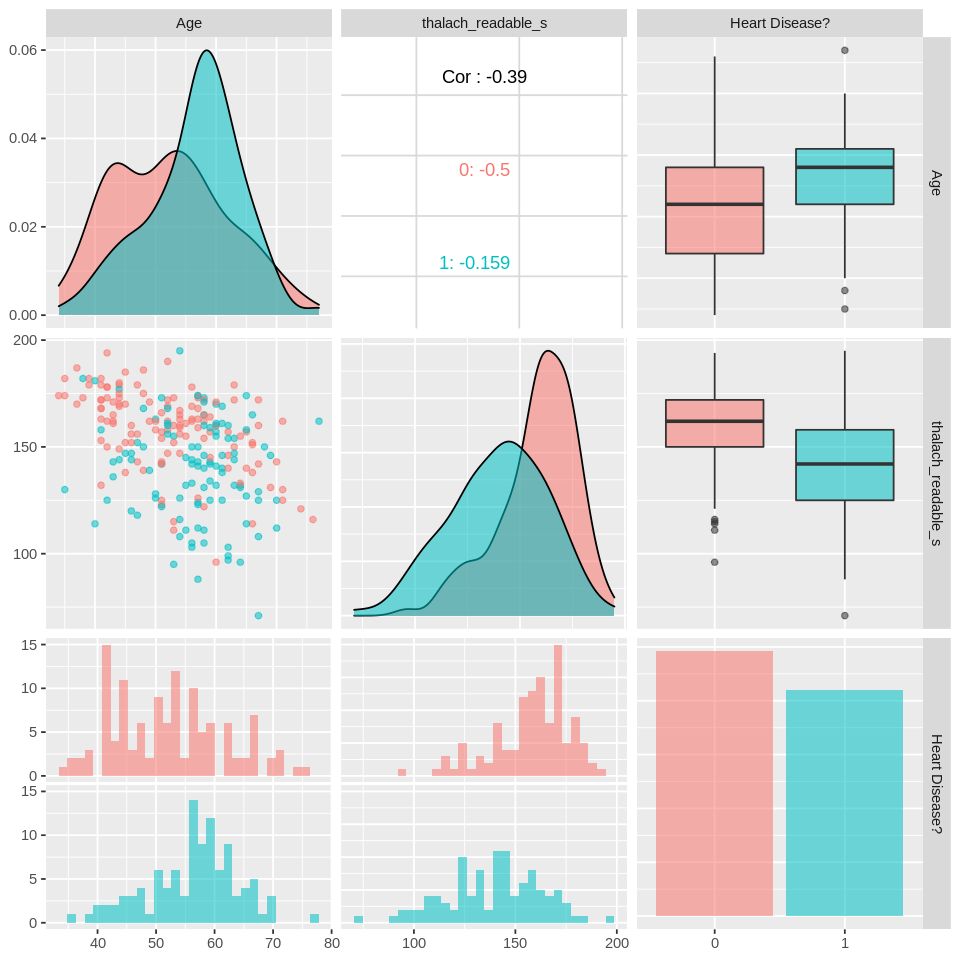

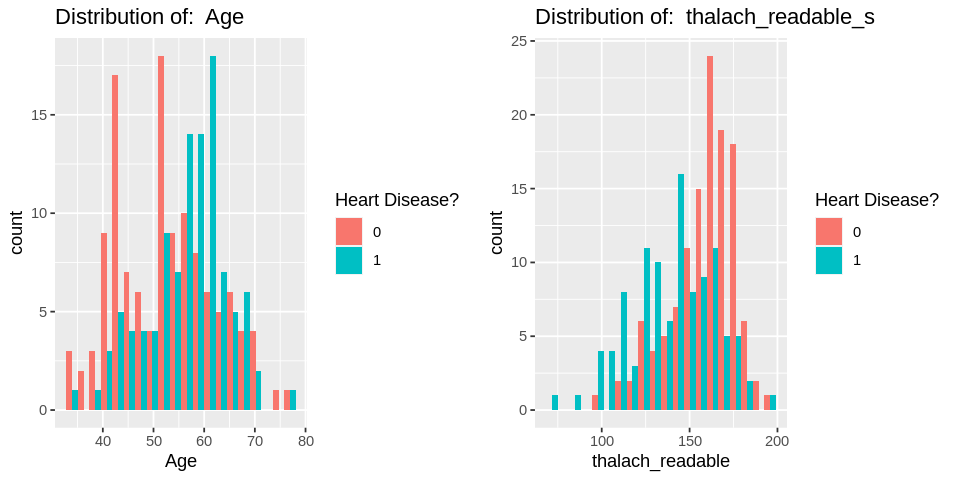

In [4]:
heart_data_train2 <- heart_data_train
names(heart_data_train2) <- map_chr(names(heart_data_train2), HumanReadableShort)
ggpairs(heart_data_train2,
  mapping=aes(colour = get(HumanReadableShort(target)), alpha=0.4))
rm(heart_data_train2)



histogramPlot <- function(p){
  ggplot(heart_data_train, aes(x=get(p), fill = get(target))) +
    geom_histogram(bins=20, position = "dodge") +
    labs(x=HumanReadable(p), fill=HumanReadableShort(target)) +
    ggtitle(paste("Distribution of: ", HumanReadableShort(p)))
}

options(repr.plot.width = default_plot_width, repr.plot.height = (default_plot_height/2) * ceiling(length(predictors)/2))
plot_grid(plotlist = map(predictors, histogramPlot), ncol = 2)
options(repr.plot.width = default_plot_width, repr.plot.height = default_plot_height)

###### Figure 1

#### Part 3 : Classification, Tuning Of The engine 

In [5]:
# Code part 3, Classification, tuning
heart_recipe <- recipe(as.formula(paste(target, "~ .")), data = heart_data_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

heart_vfold <- vfold_cv(heart_data_train, v = 5, strata = all_of(target))
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_results <- workflow() %>%
  add_recipe(heart_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = heart_vfold, grid = gridvals) %>%
  collect_metrics()

#### Part 4 : Analysis Results From Tuning

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,binary,0.7322705,5,0.04272793,Model15
16,accuracy,binary,0.7322705,5,0.04272793,Model16
13,accuracy,binary,0.7279227,5,0.04423322,Model13
9,accuracy,binary,0.7237681,5,0.05475764,Model09
10,accuracy,binary,0.7237681,5,0.05475764,Model10
14,accuracy,binary,0.7235749,5,0.04470320,Model14


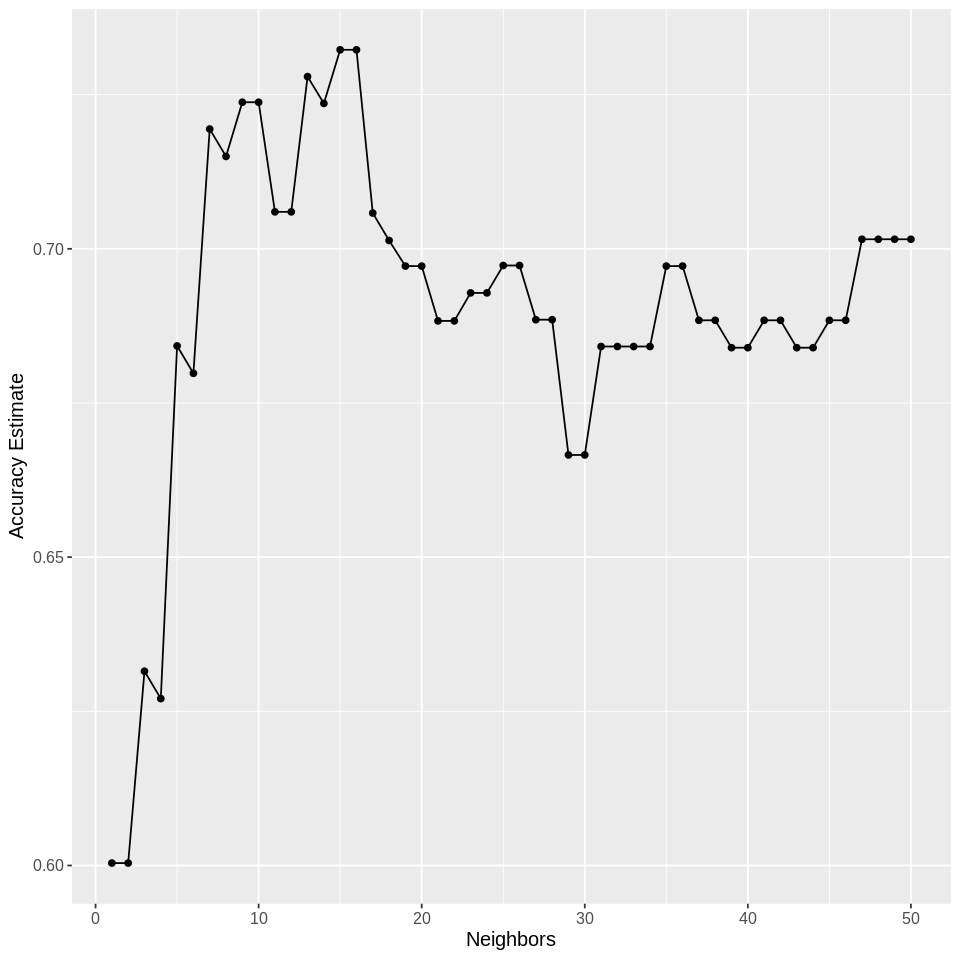

In [6]:
# Code part 4, analysis result from tuning
accuracies <- knn_results %>%
  filter(.metric == "accuracy") %>% 
  arrange(desc(mean))
head(accuracies , 6)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k
# best_k <- slice(accuracies, 1) %>% 
#   select(neighbors) %>% 
#   pull()

# print(paste("Best k value:", best_k))

###### Table 3 ; Figure 2

#### Part 5 : Using k With Highest Accuracy In The Classification model

* Below we have made a confusion map that shows how many observations were assigned correctly. The confusion map below shows that for observations with num value 0, 30 out of 41  observations were assigned correctly and for observations with num value 1, 25 out of 34  observations were assigned correctly. Explained in more detail in summary.

In [7]:
# change k based on the graph.
best_k <- 15

# Code part 5, use best_k to fit
knn_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) %>%
  set_engine("kknn") %>%
  set_mode("classification")

heart_fit <- workflow() %>%
  add_recipe(heart_recipe) %>%
  add_model(knn_spec2) %>%
  fit(heart_data_train)

heart_predict <- predict(heart_fit, heart_data_test) %>%
  bind_cols(heart_data_test) 

heart_predict_accuracy <- heart_predict %>%
  metrics(truth = all_of(target), estimate = .pred_class) %>%
  filter(.metric == "accuracy") %>%
  select(.estimate) %>%
  pull()

confusion <- heart_predict %>%
             conf_mat(truth = all_of(target), estimate = .pred_class)

print(paste("Predict Accuracy:", heart_predict_accuracy))
print("confusion map: ")
confusion

[1] "Predict Accuracy: 0.733333333333333"
[1] "confusion map: "


          Truth
Prediction  0  1
         0 30  9
         1 11 25

###### Table 4

#### Part 6 : Visualizing Final Result 

* The summary visualization below shows the testing data being assigned to num values 0 (no heart disease) or 1 (heart disease ). Observations inside the blue region are predicted as having heart disease while observations under the orange region are predicted as having no heart disease.

In [ ]:
# Code part 6, result visualizing
# Note: some code copyed from textbook 5.8

if (enablePart6){

# x <- heart_data_train[1]
x <- heart_data_train %>% select(all_of(x_var))
# y <- heart_data_train[2]
y <- heart_data_train %>% select(all_of(y_var))

others <- heart_data_train %>% 
    select(-colnames(x), -colnames(y), -all_of(target))  %>% 
    map_df(mean)

x_grid <- seq(min(x), max(x), length.out = dots)
y_grid <- seq(min(y), max(y), length.out = dots)

asgrid <- as_tibble(expand.grid(x = x_grid, y = y_grid)) 
if (!is_empty(others)){
    asgrid <- merge(asgrid, others)
}
names(asgrid)[names(asgrid) == "x"] <- colnames(x)
names(asgrid)[names(asgrid) == "y"] <- colnames(y)

knnPredGrid <- predict(heart_fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) #%>% rename(num = .pred_class)
names(prediction_table)[names(prediction_table) == ".pred_class"] <- target

wkflw_plot <- ggplot() +
  geom_point(data = heart_data_train, 
             mapping = aes(x = get(colnames(x)), 
                           y = get(colnames(y)), 
                           color = get(target)), 
             alpha = 1) +
  geom_point(data = prediction_table, 
             mapping = aes(x = get(colnames(x)), 
                           y = get(colnames(y)), 
                           color = get(target)), 
             alpha =  2.5 / dots, 
             size = 1000 / dots) +
  labs(color = HumanReadableShort(target), # "heart disease?"
       x = HumanReadable(x_var),
       y = HumanReadable(y_var)
      ) +
  ggtitle("Summary") +
  scale_color_manual(labels = c("0" = "No", "1" = "Yes"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

wkflw_plot
}

###### Figure 3

## Discussion

#### Summary 
*  We have found that as age increases and maximum heart rate decreases (thalach) the chances of heart infection disease increase. Based on these two predictors we made a classification prediction model which predicts if a person has or does not have heart disease. The testing data contained a total of 75 observations out of which 34  observations had heart disease while 41 did not, Our prediction model assigned 55 observations correctly leading to a 73.3 % accuracy (Table 4). 

  * Out of the 41 observations with no heart disease, 30 were assigned correctly which leads to a 73.2 % accuracy for observations with no heart disease (Table 4) . 
  * Out of the 34 observations with  heart disease, 25 were assigned correctly which leads to a 73.5 % accuracy for observations with heart disease (Table 4) .
 
 
* This shows our classifier is not only a majority classifier but it is assigning observations to both num values 1 and 0 .

#### Where these findings expected ?
* Yes, we had expected a relationship between our predictors and num, Our assumptions were based on past studies which we have mentioned in the report. As we were using a classification model to make predictions we were not able to use much data as there were only 4 numeric columns available in the data set, although we did expect a relation between the predictors and num we were not able to achieve a higher accuracy due to the lack of numeric biological data available to us.

#### What impact could such findings have ?
* While researching this topic we noticed that there is not much discussion around how maximum heart rate is related to heart disease. We believe such findings could increase the awareness around how a low maximum heart rate could be a sign of heart disease. 

#### What future questions could this lead to?
 * Is there a relation between all columns and num (including ones which have factors as values)  ? 
 * What combination of attribute data can lead to a more accurate diagnosis of heart disease ?
 * Do certain attributes act as better predictor variables depending on the age range of the patient?



## Citations Used

1. UCI Machine Learning Repository: Heart disease data set. (n.d.). Retrieved April 7, 2022, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

2. U.S. Department of Health and Human Services. (n.d.). Heart health and aging. National Institute on Aging. Retrieved April 7, 2022, 
   from https://www.nia.nih.gov/health/heart-health-and-aging#:~:text=Adults%20age%2065%20and%20older,risk%20of%20developing%20cardiovascular%20disease 

3. Sandvik L;Erikssen J;Ellestad M;Erikssen G;Thaulow E;Mundal R;Rodahl K; (n.d.). Heart rate increase and maximal heart rate during exercise as predictors 
   of cardiovascular mortality: A 16-year follow-up study of 1960 healthy men. Coronary artery disease. Retrieved April 7, 2022, 
   from https://pubmed.ncbi.nlm.nih.gov/8574463/ 